# Projection Mean Difference Test

In order to better isolate features for the neural network to read through, the initial data must be engineered in such a way that the correct patterns are analyzed. For image alignment, normally the goal is to optimize the output by looking at the differences in the data as opposed to the actual data itself. In order to do this, one approach is to create a mean "projection" of all of the projections and subtract that mean projection from all of the projections in the stack. This will create a new stack of data that can then be fed into the neural network and hopefully provide better results.

In this notebook, we are simply testing the idea of creating a mean projection to calculate projection differences.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)

(250, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)


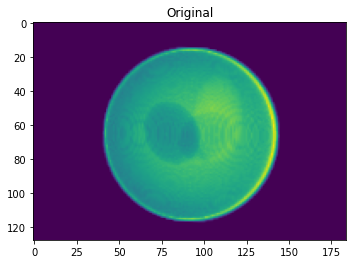

In [4]:
# Checking shape of original data
print(data.shape)
print(data[0].shape)
print(data[0][0].shape)
print(data[0][1].shape)

# Getting rid of dimensions added for neural networks in order to plot
test_proj = np.squeeze(data[0][0])

# Plot example projection
plt.imshow(test_proj[45, :, :])
plt.title('Original')
plt.show()

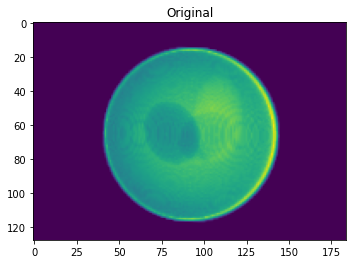

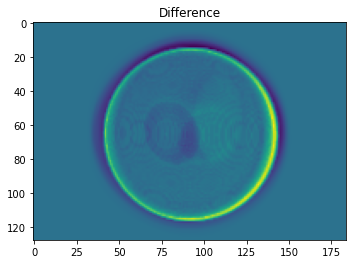

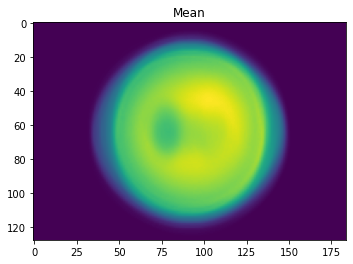

In [5]:
# Create copy of dataset for projections to be modified, also initializes array for mean projections
projections = data[:, 0].copy()
mean_projections = np.zeros((projections.shape[0]), dtype = object)

# Iterate through each projection stack
for i in range (projections.shape[0]):
    
    # Get rid of extra dimensions for neural networks and create a mean projection
    projections[i] = np.squeeze(projections[i])
    mean_projections[i] = np.mean(projections[i], axis = 0)
    
    # Display original projection for first element
    if i == 0:
        plt.imshow(test_proj[45, :, :])
        plt.title('Original')
        plt.show()
    
    # Iterate through every projection in stack
    for j in range (projections[0].shape[0]):
        
        # Change current projection to difference between current projection and mean projection
        projections[i][j] = projections[i][j] - mean_projections[i]
        
        # Plot the new projection after difference from mean applied
        if i == 0 and j == projections[0].shape[0] - 1:
            plt.imshow(test_proj[45, :, :])
            plt.title('Difference')
            plt.show()
        
    # Expand dimensions to original form for neural networks
    projections[i] = np.expand_dims(projections[i], axis = 0)
    projections[i] = np.expand_dims(projections[i], axis = 0)

plt.imshow(mean_projections[0])
plt.title('Mean')
plt.show()

In [6]:
# Create data difference array
data_diff = data.copy()

# Replace all data with the new difference projections
for i in range (data.shape[0]):
    
    data_diff[i][0] = projections[i]
    
# Check data shape
print(data_diff.shape)
print(data_diff[0].shape)
print(data_diff[0][0].shape)
print(data_diff[0][1].shape)

(250, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)


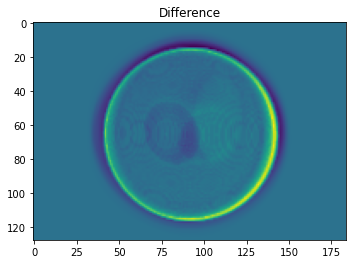

In [7]:
# Check data to ensure correctness
test_diff_proj = np.squeeze(data_diff[0][0])

plt.imshow(test_diff_proj[45, :, :])
plt.title('Difference')
plt.show()

In [8]:
# The resulting function that can be used for modifying the data
def data_mean_difference(data):
    
    # Create copy of dataset for projections to be modified, also initializes array for mean projections
    projections = data[:, 0].copy()
    mean_projections = np.zeros((projections.shape[0]), dtype = object)
    
    # Iterate through each projection stack
    for i in range (projections.shape[0]):

        # Get rid of extra dimensions for neural networks and create a mean projection
        projections[i] = np.squeeze(projections[i])
        mean_projections[i] = np.mean(projections[i], axis = 0)

        # Iterate through every projection in stack
        for j in range (projections[0].shape[0]):

            # Change current projection to difference between current projection and mean projection
            projections[i][j] = projections[i][j] - mean_projections[i]
            
        # Expand dimensions to original form for neural networks
        projections[i] = np.expand_dims(projections[i], axis = 0)
        projections[i] = np.expand_dims(projections[i], axis = 0)

    # Create data difference array
    data_diff = data.copy()

    # Replace all data with the new difference projections
    for i in range (data.shape[0]):

        data_diff[i][0] = projections[i]
        
    return data_diff

Now we have a method of changing the projection data such that it now shows the difference between each projection and the mean projection, and should hopefully help the neural network better determine the correct patterns we want it to find.